# ECE 588 — CIFAR-10 VGG (Colab Notebook)
This notebook adapts the MNIST/LeNet tutorial to **CIFAR-10 with a VGG-style model**, adds **latency measurement** and a **Score = Accuracy / Latency** metric, and prepares exports for FPGA HLS labs (saving `.pth` and `.bin` weights).

## 0. Runtime & Installs
- Please make sure you're using a **GPU runtime** in Colab: `Runtime → Change runtime type → T4/P100`.
- We install a few helper packages (e.g., `torchsummary`).

In [1]:
!pip -q install torchsummary


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Imports & Global Config

In [2]:
import os, time, math, random, json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as T

import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Paths
ROOT = Path('.')
MODELS_DIR = ROOT / 'models'
PARAMS_DIR = ROOT / 'params'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PARAMS_DIR.mkdir(parents=True, exist_ok=True)

Device: cuda


## 2. CIFAR-10 Dataset
We replace MNIST with **CIFAR-10** (3×32×32 RGB). We create train/val split and test loader.
Normalizations use the standard CIFAR-10 statistics.

In [3]:
BATCH_SIZE = 64

# Standard CIFAR-10 normalization
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
])
test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_set_full = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
test_set = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tfms)

# Create train/val split from the 50k train set
val_ratio = 0.2
num_train = len(train_set_full)
num_val = int(num_train * val_ratio)
num_train_split = num_train - num_val
train_set, val_set = torch.utils.data.random_split(train_set_full, [num_train_split, num_val],
                                                   generator=torch.Generator().manual_seed(SEED))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

classes = train_set_full.classes
print('Classes:', classes)
print(f'Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}')

Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train: 40000 | Val: 10000 | Test: 10000


### 2.1 Visualize a few samples

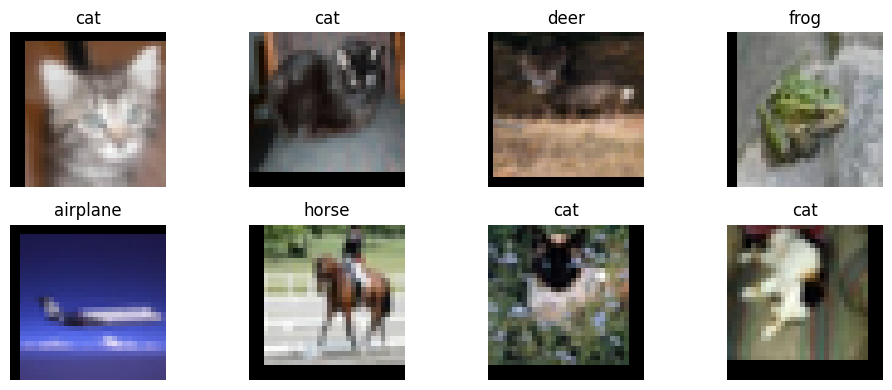

In [4]:
def imshow(img):
    img = img.cpu().numpy().transpose(1,2,0)
    # unnormalize
    m = np.array(mean); s = np.array(std)
    img = (img * s) + m
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()

## 3. VGG-like Model (Configurable)
A compact VGG-style network for CIFAR-10. You can tweak depth, channels, pooling type, and activation (`ReLU` or `Hardswish`).

In [5]:
import torch
import torch.nn as nn
from torchsummary import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# VGG Block
# ----------------------------
class VGGBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_convs=2):
        super().__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.ReLU(inplace=True))
            in_ch = out_ch

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# ----------------------------
# ReducedVGG (CIFAR-10)
# ----------------------------
class ReducedVGG(nn.Module):
    """
    Reduced VGG model for CIFAR-10
    Channels: 32 → 64 → 128 → 256
    """
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            VGGBlock(3, 32, num_convs=2),      # 32x32 → 16x16
            VGGBlock(32, 64, num_convs=2),     # 16x16 → 8x8
            VGGBlock(64, 128, num_convs=2),    # 8x8 → 4x4
            VGGBlock(128, 256, num_convs=2),   # 4x4 → 2x2
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)              # (B, 256, 2, 2)
        x = x.view(x.size(0), -1)         # flatten
        return self.classifier(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# ----------------------------
# CREATE MODEL
# ----------------------------
model = ReducedVGG(num_classes=10).to(DEVICE)
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
          VGGBlock-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

## 4. Training & Validation Utilities

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

def accuracy_from_outputs(outputs, labels):
    preds = outputs.argmax(dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

def run_epoch(data_loader, model, train=True):
    if train:
        model.train()
    else:
        model.eval()
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for images, labels in data_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            outputs = model(images)
            loss = criterion(outputs, labels)
            if train:
                loss.backward()
                optimizer.step()
        tot_loss += loss.item() * images.size(0)
        tot_correct += (outputs.argmax(1) == labels).sum().item()
        tot_count += images.size(0)
    return tot_loss / tot_count, tot_correct / tot_count

best_val_acc = 0.0
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
save_path = MODELS_DIR / 'vgg_cifar10.pth'

for epoch in range(EPOCHS):
    tr_loss, tr_acc = run_epoch(train_loader, model, train=True)
    val_loss, val_acc = run_epoch(val_loader, model, train=False)
    scheduler.step(val_acc)

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1:02d}/{EPOCHS} | '
          f'Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | '
          f'Val Loss {val_loss:.4f} Acc {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(),
                    'config': {'activation':'hardswish','pool':'avg'}},
                   save_path)
        print('  ↳ Saved new best model.')

Epoch 01/20 | Train Loss 1.5613 Acc 0.4076 | Val Loss 1.2932 Acc 0.5295
  ↳ Saved new best model.
Epoch 02/20 | Train Loss 1.1395 Acc 0.5979 | Val Loss 1.0397 Acc 0.6254
  ↳ Saved new best model.
Epoch 03/20 | Train Loss 0.9501 Acc 0.6685 | Val Loss 0.9060 Acc 0.6784
  ↳ Saved new best model.
Epoch 04/20 | Train Loss 0.8414 Acc 0.7141 | Val Loss 0.8009 Acc 0.7228
  ↳ Saved new best model.
Epoch 05/20 | Train Loss 0.7583 Acc 0.7458 | Val Loss 0.7857 Acc 0.7383
  ↳ Saved new best model.
Epoch 06/20 | Train Loss 0.7020 Acc 0.7667 | Val Loss 0.6643 Acc 0.7764
  ↳ Saved new best model.
Epoch 07/20 | Train Loss 0.6588 Acc 0.7827 | Val Loss 0.6708 Acc 0.7662
Epoch 08/20 | Train Loss 0.6163 Acc 0.7980 | Val Loss 0.5895 Acc 0.7979
  ↳ Saved new best model.
Epoch 09/20 | Train Loss 0.5831 Acc 0.8087 | Val Loss 0.5575 Acc 0.8051
  ↳ Saved new best model.
Epoch 10/20 | Train Loss 0.5450 Acc 0.8201 | Val Loss 0.5384 Acc 0.8193
  ↳ Saved new best model.
Epoch 11/20 | Train Loss 0.5266 Acc 0.8268 | V

### 4.1 Plot Training Curves

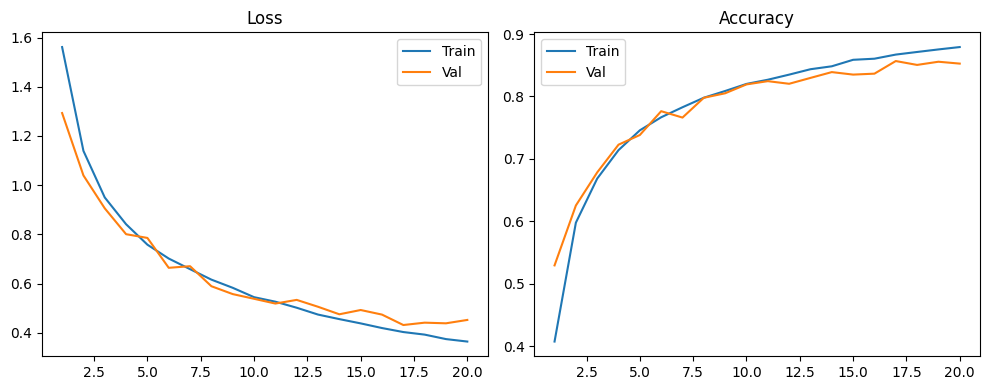

In [7]:
epochs = np.arange(1, len(history['train_loss'])+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train')
plt.plot(epochs, history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train')
plt.plot(epochs, history['val_acc'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

## 5. Test, Latency, and SCORE
- We evaluate on the test set.
- Latency is measured **per-sample** (batch size 1 timing inside the loop). We compute the average latency in milliseconds.
- **SCORE = Accuracy / AvgLatency(ms)** (higher is better).

In [8]:
# Reload checkpoint
ckpt = torch.load(save_path, map_location=DEVICE)

# Build ReducedVGG model
model = ReducedVGG(num_classes=10).to(DEVICE)

# Load weights
model.load_state_dict(ckpt['model_state'], strict=True)
model.eval()

# Evaluate accuracy + per-sample latency
all_labels, all_preds = [], []
latencies_ms = []

with torch.no_grad():
    for images, labels in test_loader:
        for i in range(images.size(0)):
            img = images[i:i+1].to(DEVICE)
            lab = labels[i:i+1].to(DEVICE)

            start = time.perf_counter()
            out = model(img)
            end = time.perf_counter()

            latencies_ms.append((end - start) * 1000.0)

            pred = out.argmax(1).item()
            all_preds.append(pred)
            all_labels.append(lab.item())

# Compute metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
avg_latency_ms = float(np.mean(latencies_ms))
score = test_acc / avg_latency_ms

# Print results
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Average Per-sample Latency: {avg_latency_ms:.3f} ms")
print(f"SCORE = Accuracy / Latency(ms) = {score:.6f}")


C:\Users\ayush\AppData\Local\Temp\ipykernel_50712\3966908781.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(save_path, map_location=DEVICE)


Test Accuracy: 85.59%
Average Per-sample Latency: 2.454 ms
SCORE = Accuracy / Latency(ms) = 0.348735


### 5.1 Confusion Matrix

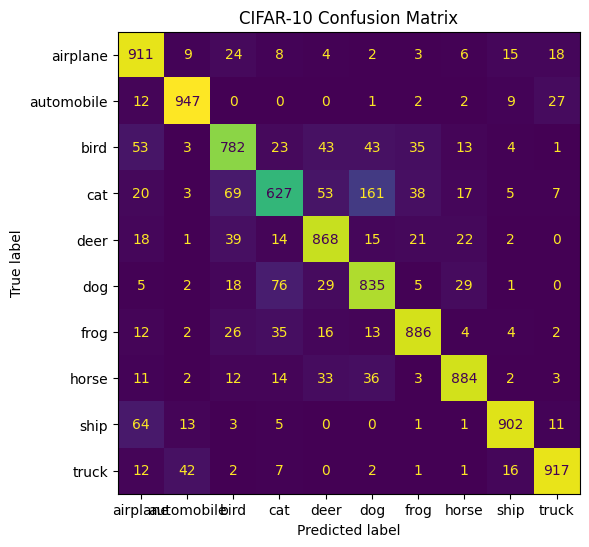

In [9]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, colorbar=False)
plt.title('CIFAR-10 Confusion Matrix')
plt.show()

## 6. Quantization Comparison (INT8 / INT16 / INT32)
You will receive TA code for quantization. After you evaluate each precision, record the results below. (Run your quantized model through the latency harness above.)

| Precision | Accuracy | Avg Latency (ms) | SCORE = Acc/Lat |
|---|---:|---:|---:|
| FP32 (baseline) |  |  |  |
| INT32 |  |  |  |
| INT16 |  |  |  |
| INT8  |  |  |  |

1) Core quantization utilities (uniform symmetric, per-tensor)

In [10]:
import torch
import numpy as np
from pathlib import Path
from copy import deepcopy
import time

# ---------- Uniform symmetric per-tensor quant/dequant ----------
def _qparams_symmetric_per_tensor(t: torch.Tensor, bits: int):
    qmax = (1 << (bits - 1)) - 1  # e.g., 127 for int8
    max_abs = t.abs().max()
    scale = (max_abs / qmax) if max_abs > 0 else torch.tensor(1.0, device=t.device, dtype=t.dtype)
    return scale, qmax

def quantize_dequantize_tensor(t: torch.Tensor, bits: int):
    # Per-tensor symmetric quantization → int → back to float
    scale, qmax = _qparams_symmetric_per_tensor(t, bits)
    q = torch.clamp(torch.round(t / scale), min=-qmax-1, max=qmax)
    return (q * scale).to(t.dtype)

# ---------- Weight-only quantization ----------
@torch.no_grad()
def quantize_model_weights(model: torch.nn.Module, bits: int):
    qmodel = deepcopy(model)
    for n, m in qmodel.named_modules():
        if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
            m.weight.copy_(quantize_dequantize_tensor(m.weight, bits))
            if m.bias is not None:
                # Bias often kept higher precision; we leave as-is
                pass
    return qmodel

# ---------- Activation calibration (per-module output, symmetric) ----------
class ActCalibrator(torch.nn.Module):
    def __init__(self, model, modules_to_calib=(torch.nn.Conv2d, torch.nn.Linear)):
        super().__init__()
        self.model = model
        self.modules_to_calib = modules_to_calib
        self.handles = []
        self.act_max = {}  # name -> max_abs

        def hook(name):
            def _fn(_m, _in, out):
                with torch.no_grad():
                    max_abs = out.detach().abs().max().item()
                    self.act_max[name] = max(self.act_max.get(name, 0.0), max_abs)
            return _fn

        # register forward hooks
        for name, m in self.model.named_modules():
            if isinstance(m, modules_to_calib):
                self.handles.append(m.register_forward_hook(hook(name)))

    def forward(self, x):
        return self.model(x)

    def clear(self):
        for h in self.handles:
            h.remove()
        self.handles = []

# Apply act quantization during forward (quantize→dequantize module outputs)
class ActQuantWrapper(torch.nn.Module):
    def __init__(self, model, act_max_dict, act_bits=8, modules_to_quant=(torch.nn.Conv2d, torch.nn.Linear)):
        super().__init__()
        self.model = model
        self.act_max = act_max_dict
        self.act_bits = act_bits
        self.modules_to_quant = modules_to_quant

        self.handles = []
        def make_hook(name):
            def _hook(_m, _in, out):
                max_abs = self.act_max.get(name, None)
                if max_abs is None or max_abs == 0:
                    return out
                # build scale from observed max
                qmax = (1 << (self.act_bits - 1)) - 1
                scale = max_abs / qmax
                q = torch.clamp(torch.round(out/scale), min=-qmax-1, max=qmax)
                return (q * scale).to(out.dtype)
            return _hook

        for name, m in self.model.named_modules():
            if isinstance(m, self.modules_to_quant):
                self.handles.append(m.register_forward_hook(make_hook(name)))

    def forward(self, x):
        return self.model(x)

    def clear(self):
        for h in self.handles:
            h.remove()
        self.handles = []


Weight-Only PTQ (paste two cells)

In [11]:
def evaluate_accuracy_latency(model, test_loader, device, warmup=10):
    model.eval()
    all_labels, all_preds = [], []
    lat_ms = []

    # warm-up
    with torch.no_grad():
        it = iter(test_loader)
        for _ in range(min(warmup, len(test_loader))):
            imgs, _ = next(it)
            imgs = imgs[:1].to(device)  # single-sample warmup
            _ = model(imgs)

    with torch.no_grad():
        for images, labels in test_loader:
            for i in range(images.size(0)):
                img = images[i:i+1].to(device)
                lab = labels[i:i+1].to(device)

                start = time.perf_counter()
                out = model(img)
                end = time.perf_counter()

                lat_ms.append((end - start) * 1000.0)
                pred = out.argmax(1).item()
                all_preds.append(pred)
                all_labels.append(lab.item())

    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    avg_lat = float(np.mean(lat_ms))
    return acc, avg_lat

def run_weight_only_ptq(model_fp, bits_list, test_loader, device):
    results = []
    for bits in bits_list:
        qmodel = quantize_model_weights(model_fp, bits).to(device)
        acc, lat = evaluate_accuracy_latency(qmodel, test_loader, device)
        score = acc / lat
        results.append({'mode': f'W-only INT{bits}', 'accuracy': float(acc),
                        'avg_latency_ms': float(lat), 'score': float(score)})
        print(f"[W-only INT{bits}] acc={acc:.4f}, lat={lat:.3f} ms, score={score:.6f}")
    return results


In [12]:
from copy import deepcopy

model_fp = deepcopy(model).to(DEVICE)  # 'model' is your best VGG loaded already
ptq_weight_results = run_weight_only_ptq(
    model_fp,
    bits_list=[8, 16, 32],
    test_loader=test_loader,
    device=DEVICE
)
ptq_weight_results


[W-only INT8] acc=0.8567, lat=2.553 ms, score=0.335543
[W-only INT16] acc=0.8560, lat=2.706 ms, score=0.316301
[W-only INT32] acc=0.8559, lat=2.510 ms, score=0.341022


[{'mode': 'W-only INT8',
  'accuracy': 0.8567,
  'avg_latency_ms': 2.5531774803530425,
  'score': 0.3355426744095907},
 {'mode': 'W-only INT16',
  'accuracy': 0.856,
  'avg_latency_ms': 2.706281230133027,
  'score': 0.31630119976774307},
 {'mode': 'W-only INT32',
  'accuracy': 0.8559,
  'avg_latency_ms': 2.5098052286077293,
  'score': 0.341022478654567}]

Weight+Activation PTQ

In [13]:
@torch.no_grad()
def calibrate_activations(model_fp, calib_loader, device, num_batches=50):
    cal = ActCalibrator(deepcopy(model_fp).to(device))
    cal.eval()
    n = 0
    for images, _ in calib_loader:
        images = images.to(device)
        _ = cal(images)
        n += 1
        if n >= num_batches: break
    cal.clear()
    return cal.act_max  # dict: module_name -> max_abs

def run_weight_act_ptq(model_fp, bits_w, bits_a, calib_loader, test_loader, device, calib_batches=50):
    # Quantize weights
    qmodel_w = quantize_model_weights(model_fp, bits_w).to(device)
    # Calibrate activations on the weight-quantized model
    act_max = calibrate_activations(qmodel_w, calib_loader, device, num_batches=calib_batches)
    # Wrap with activation quantizer
    qwrap = ActQuantWrapper(qmodel_w, act_max, act_bits=bits_a).to(device)
    acc, lat = evaluate_accuracy_latency(qwrap, test_loader, device)
    score = acc / lat
    print(f"[W{bits_w}/A{bits_a}] acc={acc:.4f}, lat={lat:.3f} ms, score={score:.6f}")
    # clean hooks
    qwrap.clear()
    return {'mode': f'W{bits_w}/A{bits_a}', 'accuracy': float(acc),
            'avg_latency_ms': float(lat), 'score': float(score)}


In [14]:
# Use your validation loader as a calibration set
calib_loader = val_loader

ptq_wa_results = []
for bw in [8, 16, 32]:
    for ba in [8, 16, 32]:
        res = run_weight_act_ptq(
            deepcopy(model).to(DEVICE),  # start from your FP model
            bw, ba,
            calib_loader, test_loader, DEVICE,
            calib_batches=50
        )
        ptq_wa_results.append(res)

ptq_wa_results


[W8/A8] acc=0.8572, lat=4.218 ms, score=0.203201
[W8/A16] acc=0.8566, lat=4.217 ms, score=0.203144
[W8/A32] acc=0.8567, lat=4.240 ms, score=0.202043
[W16/A8] acc=0.8553, lat=4.131 ms, score=0.207067
[W16/A16] acc=0.8559, lat=4.118 ms, score=0.207864
[W16/A32] acc=0.8560, lat=4.158 ms, score=0.205874
[W32/A8] acc=0.8540, lat=4.244 ms, score=0.201236
[W32/A16] acc=0.8559, lat=4.271 ms, score=0.200420
[W32/A32] acc=0.8559, lat=4.349 ms, score=0.196796


[{'mode': 'W8/A8',
  'accuracy': 0.8572,
  'avg_latency_ms': 4.218486931012012,
  'score': 0.20320081916061747},
 {'mode': 'W8/A16',
  'accuracy': 0.8566,
  'avg_latency_ms': 4.216712150233798,
  'score': 0.20314405382224285},
 {'mode': 'W8/A32',
  'accuracy': 0.8567,
  'avg_latency_ms': 4.240193299204111,
  'score': 0.20204267578103186},
 {'mode': 'W16/A8',
  'accuracy': 0.8553,
  'avg_latency_ms': 4.130556488432921,
  'score': 0.20706653023512808},
 {'mode': 'W16/A16',
  'accuracy': 0.8559,
  'avg_latency_ms': 4.117588040884584,
  'score': 0.20786440787702656},
 {'mode': 'W16/A32',
  'accuracy': 0.856,
  'avg_latency_ms': 4.157886640029028,
  'score': 0.20587381862676848},
 {'mode': 'W32/A8',
  'accuracy': 0.854,
  'avg_latency_ms': 4.243763950793072,
  'score': 0.20123645186259828},
 {'mode': 'W32/A16',
  'accuracy': 0.8559,
  'avg_latency_ms': 4.2705258497036995,
  'score': 0.20042028315070018},
 {'mode': 'W32/A32',
  'accuracy': 0.8559,
  'avg_latency_ms': 4.349163922457956,
  'sc

Results Table

In [15]:
def print_results_table(rows, title="Quantization Results"):
    import pandas as pd
    df = pd.DataFrame(rows)
    display(df.sort_values("score", ascending=False).reset_index(drop=True))
    return df

all_results = []
all_results += ptq_weight_results
all_results += ptq_wa_results

results_df = print_results_table(all_results)


,mode,accuracy,avg_latency_ms,score
0,W-only INT32,0.8559,2.509805,0.341022
1,W-only INT8,0.8567,2.553177,0.335543
2,W-only INT16,0.8560,2.706281,0.316301
3,W16/A16,0.8559,4.117588,0.207864
4,W16/A8,0.8553,4.130556,0.207067
5,W16/A32,0.8560,4.157887,0.205874
6,W8/A8,0.8572,4.218487,0.203201
7,W8/A16,0.8566,4.216712,0.203144
8,W8/A32,0.8567,4.240193,0.202043
9,W32/A8,0.8540,4.243764,0.201236


## 7. Export Weights: `.pth` → `.bin` (per-layer)
This exports each tensor in the model's `state_dict()` into a `.bin` file under `./params/`.
- **Order**: tensors are saved in contiguous row-major order.
- **DType**: float32 by default (your quantization pipeline may change this).

In [ ]:

from pathlib import Path
import numpy as np
import torch
from copy import deepcopy

def export_model_bins(model_any, out_dir: Path, dtype=np.float32):
    out_dir.mkdir(parents=True, exist_ok=True)
    with torch.no_grad():
        for name, t in model_any.state_dict().items():
            arr = t.detach().cpu().numpy().astype(dtype)
            (out_dir / (name.replace('.', '_') + '.bin')).write_bytes(arr.tobytes())
    print("Exported .bin tensors to", out_dir)

# Example: export INT8 weight-only model (float bins for now)
best_qmodel = quantize_model_weights(deepcopy(model).to(DEVICE), bits=8)
export_model_bins(best_qmodel, Path("./params_int8"), dtype=np.float32)


## 8. HLS Design Hints (Readme-style)
- Start by identifying **which conv blocks** dominate latency using a profiler.
- Map conv → HLS kernel with **tiling + line buffers + loop pipelining**.
- Consider **Hardswish** vs **ReLU** when targeting hardware (approximation cost vs benefit).
- Keep an eye on DSP/BRAM utilization. Reduce unrolling factors if you exceed resources.
- Follow your Lab 3/4 make/TCL flow to package IP and integrate with PYNQ.
